In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 3.5MB/s 


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
########################################
''' Imports '''

from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from glob import glob
import os, csv
import random
import time
from random import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image 
from IPython.display import display 
from PIL import Image
from PIL import ImageFile 

from tqdm import tqdm

from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs

print("Import finished")

Using TensorFlow backend.


Import finished


In [0]:
########################################
''' Class '''

class Traffic_Sign:
    """ A Single Traffic sign model """
    
    def __init__(self, filePath, fileName, width, height, x1, y1, x2, y2, classTxt, classID):
        self.filePath = filePath
        self.fileName = fileName
        self.width = width
        self.height = height
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.classTxt = classTxt
        self.classID = classID 
        

In [0]:
########################################
''' Print helper function '''

# pretty print Traffic Sign object
def ts_pretty_print(ts):
    print("File: {} has name {}, with classID: {}".format(ts.fileName, ts.classTxt, ts.classID))
    


In [0]:
'''Google colab'''

TSName_txt_path = "drive/My Drive/MLND_Traffic_Sign_Recognition/Dataset/reducedSetTS.txt"
label_map_output_path = "drive/My Drive/MLND_Traffic_Sign_Recognition/obj_detection/data/TS_label_map.pbtxt"

# All standard pictures in this folder are with its class name and .png format e.g. A1A.png
standard_folder = "drive/My Drive/MLND_Traffic_Sign_Recognition/Standards"
standard_img_extension = ".png"

# dataset path
dataset_directory = "drive/My Drive/MLND_Traffic_Sign_Recognition/Dataset"
training_dataset_directory = os.path.join(dataset_directory, "Training")
testing_dataset_directory = os.path.join(dataset_directory, "Testing")

# Store all images in png under training/testing folder
png_training_dataset_dir = os.path.join(dataset_directory, 'png_training')
png_testing_dataset_dir = os.path.join(dataset_directory, 'png_testing')

# tfRecords output path
tfRecordsDir = "drive/My Drive/MLND_Traffic_Sign_Recognition/obj_detection/tfRecords"



In [0]:
# create classID and className pairs for 62 Traffic Signs
with open(TSName_txt_path) as f:
    TSName_62 = f.readlines()
# remove whitespace characters
TSName_62 = [x.strip() for x in TSName_62[0:]]

In [0]:
########################################
''' Load dataset into variable '''

# function to load training, test, and validation datasets into variables 
def load_dataset(path):
    all_files = []
    for eachfolder in os.listdir(path):
        abs_loc = path + "/" + eachfolder
        if not os.path.isdir(abs_loc):
            continue

        #open csv for this folder
        with open(abs_loc + "/GT-" + eachfolder + ".csv", "r") as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=';')
            next(csv_reader, None) # skip header
            
            #create traffic sign object
            for row in csv_reader:
                abs_file_loc = abs_loc + "/" + row[0]
                all_files.append(Traffic_Sign(abs_file_loc, row[0], row[1], row[2], row[3], row[4], row[5], row[6], TSName_62[int(row[7])], row[7]))

            csv_file.close()
    return all_files

def extract_X_and_Y(all_objs):
    X = []
    Y = []
    for ts in all_objs:
        X.append(ts.filePath)
        Y.append(ts.classID)
    return X, Y


# load train and test datasets into list of objects of Traffic signs
#all_training_objs = load_dataset("/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Dataset/Training") # a list of training traffic_sign_collection
#all_testing_and_validation_objs = load_dataset("/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Dataset/Testing")  # a list of testing traffic_sign_collection

all_training_objs = load_dataset(training_dataset_directory) # a list of training traffic_sign_collection
all_testing_and_validation_objs = load_dataset(testing_dataset_directory)  # a list of testing traffic_sign_collection


# shuffle training objects and testing objects 
shuffle(all_training_objs)
shuffle(all_testing_and_validation_objs)

# extract training files and targets
all_training_files, all_training_targets = extract_X_and_Y(all_training_objs)

# extract testing files and targets and split into validation and test
X_temp, Y_temp = extract_X_and_Y(all_testing_and_validation_objs)

# merge X_temp and all_training_files to get total files
traffic_sign_files_total = X_temp + all_training_files
traffic_sign_targets_total = Y_temp + all_training_targets

# get all validation fiels and all test files
all_validation_files, all_test_files, all_validation_targets, all_test_targets = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)



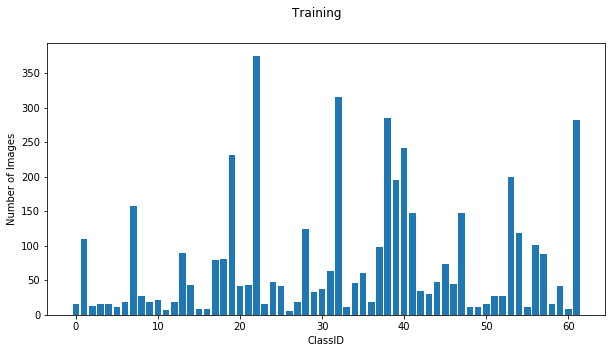

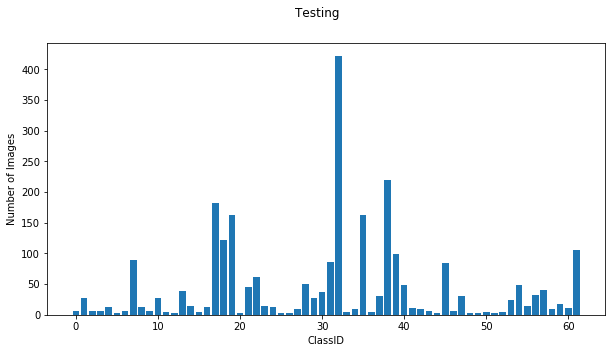

In [0]:
########################################
''' Plot data '''
import matplotlib.pyplot as plt
def show_dataset_plot(all_objs, sub_title):
    graph_names = list(range(0, 62)) #class ID
    graph_values = [0] * 62 #count values for each class
    for obj in all_objs:
        graph_values[int(obj.classID)] += 1
        

    plt.figure(1, figsize=(10, 5))
    plt.bar(graph_names, graph_values)
    plt.xlabel("ClassID")
    plt.ylabel("Number of Images")
    plt.suptitle(sub_title)
    plt.show()

show_dataset_plot(all_training_objs, "Training")
show_dataset_plot(all_testing_and_validation_objs, "Testing")

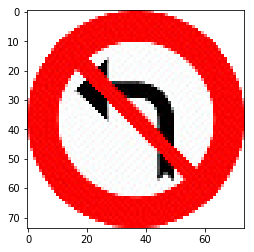

drive/My Drive/MLND_Traffic_Sign_Recognition/Standards/C31LEFT.png


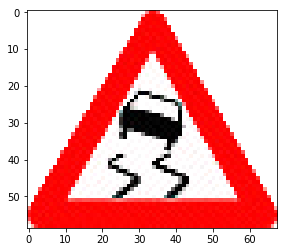

drive/My Drive/MLND_Traffic_Sign_Recognition/Standards/A15.png


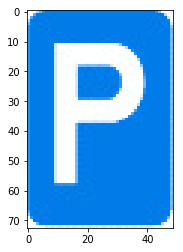

drive/My Drive/MLND_Traffic_Sign_Recognition/Standards/E9a.png


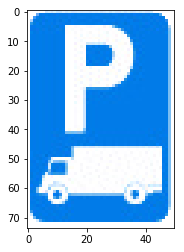

drive/My Drive/MLND_Traffic_Sign_Recognition/Standards/E9c.png


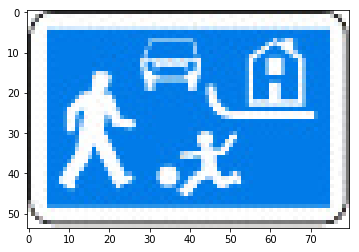

drive/My Drive/MLND_Traffic_Sign_Recognition/Standards/F12a.png


In [0]:
########################################
''' Load the definition (standards) of our 62 traffic sign images '''
''' from 210 total traffic sign image dataset '''
def show_my_image(img_path):
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
        
# display some standard images
for i in range(5):
    img_name = TSName_62[random.randint(0, 61)] + standard_img_extension
    img_path = os.path.join(standard_folder, img_name)
    show_my_image(img_path)
    print(img_path)


In [0]:
########################################
''' Print statistics and sample img '''

print('There are %d total traffic sign categories.' % len(set(all_training_targets)))
print('There are %d total traffic sign images.' % len(traffic_sign_files_total))
print('There are %d training traffic sign images.' % len(all_training_targets))
print('There are %d validation traffic sign images.' % len(all_validation_targets))
print('There are %d test traffic sign images.'% len(all_test_targets))

# To check if our targets match files
def file_target_consistent():
    checklist_valification = random.sample(range(len(traffic_sign_files_total)), 100)
    for i in checklist_valification:
        if not int(traffic_sign_files_total[i][-18:-16]) == int(traffic_sign_targets_total[i]):
            print("Test Failed")
            return
    print("File and Target are consistent")

file_target_consistent()


# TODO: assign names to each class, show a few images



There are 62 total traffic sign categories.
There are 7161 total traffic sign images.
There are 4591 training traffic sign images.
There are 1285 validation traffic sign images.
There are 1285 test traffic sign images.
File and Target are consistent


In [0]:
########################################
''' Use a pre-trained model to detect street signs in image -- First Try'''
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

W0717 18:59:58.595309 140660961286016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 18:59:58.638585 140660961286016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 18:59:58.651883 140660961286016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0717 18:59:58.690098 140660961286016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0717 18:59:58.691424

102858752/102853048 [==============================] - 1s 0us/step


In [0]:
ResNet50_model.save_weights('drive/My Drive/MLND_Traffic_Sign_Recognition/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
model_file = drive.CreateFile({'title' : 'drive/My Drive/MLND_Traffic_Sign_Recognition/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5'})                       


In [0]:
model_file.SetContentFile('drive/My Drive/MLND_Traffic_Sign_Recognition/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5')                       
model_file.Upload()
# download to google drive                       


W0717 19:00:30.951445 140660961286016 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [0]:
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1SnDwPrMkH0p-_TYMTYQRdLaa3ocjB2pn'})

In [0]:
file_obj = drive.CreateFile({'id': '1SnDwPrMkH0p-_TYMTYQRdLaa3ocjB2pn'})                       
file_obj.GetContentFile('last_weight.h5')

In [0]:
########################################
''' Pre-process the images '''

# Keras CNNs require 4D array with shape (nb_samples,rows,columns,channels)
#   nb_samples: the total number of images (or samples)
#   rows: the number of rows for each image.
#   columns: the number of columns for each image.
#   channels: the number of channels for each image.

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [0]:
########################################
''' Predict the image using ResNet50 '''

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [0]:
########################################
''' Sign Detector '''

def sign_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    #print(prediction)
    return (prediction == 919) # 919 is street sign

In [0]:
########################################
''' Test predictor performance '''

def test_sign_detector_performance(images_needed_check):
    # number of success of predicting there is traffic signs 
    # in images that contain traffic sign
    positive_success = []
    all_success = [1]*len(images_needed_check)
    
    for i in images_needed_check:
        if sign_detector(i):
            positive_success.append(1)
        else:
            positive_success.append(0)
    print(f1_score(all_success, positive_success))
        


In [0]:
########################################
''' check how the ImageNet weight ResNet50 model perform on our problem '''
from os import listdir
from os.path import isfile, join

# test traffic signs
print('All_training_files:')
test_sign_detector_performance(traffic_sign_files_total)
print('All_validation_files:')
test_sign_detector_performance(all_validation_files)
print('All_test_files:')
test_sign_detector_performance(all_test_files)



0.42355531095211885
All_training_files: None
0.3816120906801007
All_validation_files: None
0.4027346177750155
All_test_files: None


In [0]:
########################################
''' Fine tuning our own model '''

# source code: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet50_model(img_rows, img_cols, color_type=1, num_classes=None):
    imagenet_weights_path = "last_weight.h5"
    '''
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    '''
    img_input = Input(shape=(img_rows, img_cols, color_type))
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), name="conv1", strides=(2, 2))(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    # original fully connected layer 
    x_orig = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_orig = Flatten()(x_orig)
    x_orig = Dense(1000, activation='softmax', name='fcImageNet')(x_orig)
    
    # Create model
    model = Model(img_input, x_orig)
    
    # load image net weight
    model.load_weights(imagenet_weights_path)
    
    # replace softmax layer for transfer learning
    x_new = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_new = Flatten()(x_new)
    x_new = Dense(num_classes, activation='softmax', name='fcTS')(x_new)
    
    model = Model(img_input, x_new)
    
    model.summary()
    return model

In [0]:
########################################
''' Train our model '''
img_row = 224
img_col = 224
channel = 3
num_class = 62 #len(set(all_training_targets))
batch_size = 16
epochs = 25

TS_model = resnet50_model(img_row, img_col, channel, num_class)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
TS_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


W0707 17:57:47.549930 139782734571392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0707 17:57:51.129632 139782734571392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
# pre-process the data for Keras
train_tensors = paths_to_tensor(all_training_files).astype('float32')/255
valid_tensors = paths_to_tensor(all_validation_files).astype('float32')/255
test_tensors = paths_to_tensor(all_test_files).astype('float32')/255



100%|██████████| 1285/1285 [00:02<00:00, 610.64it/s]


In [0]:
from sklearn.preprocessing import OneHotEncoder

def oneHotEncodeTargets(list_of_targets):
    onehot_encoded = list()
    for value in list_of_targets:
        letter = [0 for _ in range(62)]
        letter[int(value)] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded)

all_training_targets = oneHotEncodeTargets(all_training_targets)
all_test_targets = oneHotEncodeTargets(all_test_targets)
all_validation_targets = oneHotEncodeTargets(all_validation_targets)

In [0]:
TS_model.fit(train_tensors, all_training_targets,
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True,
              verbose=1,
              validation_data=(valid_tensors, all_validation_targets),
              )


W0707 19:01:59.369819 139782734571392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4591 samples, validate on 1285 samples
Epoch 1/25
4591/4591 [==============================] - 76s 17ms/step - loss: 0.6716 - acc: 0.8477 - val_loss: 0.3147 - val_acc: 0.9315
Epoch 2/25
4591/4591 [==============================] - 67s 15ms/step - loss: 0.0730 - acc: 0.9824 - val_loss: 0.1200 - val_acc: 0.9743
Epoch 3/25
4591/4591 [==============================] - 68s 15ms/step - loss: 0.0126 - acc: 0.9978 - val_loss: 0.0572 - val_acc: 0.9907
Epoch 4/25
4591/4591 [==============================] - 69s 15ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0663 - val_acc: 0.9875
Epoch 5/25
4591/4591 [==============================] - 69s 15ms/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0680 - val_acc: 0.9883
Epoch 6/25
4591/4591 [==============================] - 69s 15ms/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0647 - val_acc: 0.9891
Epoch 7/25
4591/4591 [==============================] - 69s 15ms/step - loss: 9.1525e-04 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.9

In [0]:
TS_model.save("/content/drive/My Drive/MLND_Traffic_Sign_Recognition/trained_resnet50/TS_resnet50.h5")


In [0]:
TS_model.load_weights("/content/drive/My Drive/MLND_Traffic_Sign_Recognition/trained_resnet50/TS_resnet50.h5")
#TS_model.load_weights("C:/Users/ksu/Desktop/ML/TSR_capstone/MLND_Traffic_Sign_Recognition/trained_resnet50/TS_resnet50.h5")

In [0]:
# Prediction
ts_prediction = [np.argmax(TS_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

In [0]:
# Metric 1: accuracy score
test_accuracy = 100*np.sum(np.array(ts_prediction)==np.argmax(all_test_targets, axis=1))/len(ts_prediction)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 99.3774%


In [0]:
# Metric 2: F_1 score
test_accuracy_f1 = f1_score(np.argmax(all_test_targets, axis=1), np.array(ts_prediction), average='weighted') 
print("f_1 score: {}".format(str(test_accuracy_f1)))

f_1 score: 0.9940646687515156


In [0]:
l1 = [0, 1, 1, 2, 1, 1, 0, 0, 1, 2]
l2 = [0, 1, 0, 2, 0, 2, 0, 2, 1, 1]
print(f1_score(l1, l2, average="weighted")) 

0.5014285714285714


In [0]:
# alternative test
TS_model.load_weights("/content/drive/My Drive/MLND_Traffic_Sign_Recognition/trained_resnet50/TS_resnet50.h5")

ts_pred_index = []
ts_pred_value = []

for tensor in test_tensors:
    pred = TS_model.predict(np.expand_dims(tensor, axis=0))
    pred_index = np.argmax(pred)
    pred_value = pred[0][pred_index]
    ts_pred_index.append(pred_index)
    ts_pred_value.append(pred_value)

print(ts_pred_index)
print(ts_pred_value)

    

[1, 38, 57, 38, 53, 38, 32, 38, 28, 35, 17, 51, 32, 45, 50, 7, 38, 38, 61, 38, 17, 19, 18, 61, 54, 18, 32, 40, 19, 37, 35, 35, 35, 31, 61, 38, 17, 32, 53, 1, 38, 32, 57, 17, 32, 28, 19, 56, 19, 16, 32, 32, 61, 32, 32, 41, 32, 43, 38, 32, 17, 35, 32, 19, 18, 38, 18, 2, 32, 19, 31, 19, 35, 32, 39, 10, 35, 51, 61, 32, 32, 7, 57, 39, 30, 47, 32, 31, 21, 32, 17, 32, 53, 39, 17, 35, 17, 31, 21, 17, 35, 38, 35, 18, 38, 38, 32, 32, 7, 19, 35, 32, 18, 35, 35, 60, 18, 32, 17, 47, 35, 19, 38, 19, 43, 57, 28, 45, 59, 13, 7, 23, 19, 17, 32, 5, 18, 35, 22, 39, 32, 17, 18, 18, 53, 17, 17, 32, 45, 47, 32, 19, 47, 2, 39, 21, 17, 35, 19, 54, 45, 13, 35, 38, 17, 17, 35, 32, 19, 37, 32, 38, 32, 17, 55, 28, 18, 61, 38, 59, 4, 30, 32, 57, 35, 45, 32, 39, 32, 32, 32, 18, 48, 61, 35, 18, 38, 18, 19, 31, 19, 7, 32, 17, 19, 21, 19, 38, 52, 19, 37, 4, 10, 17, 32, 39, 31, 32, 37, 17, 35, 37, 32, 32, 7, 47, 38, 31, 19, 29, 31, 32, 38, 61, 17, 32, 47, 19, 21, 19, 35, 56, 53, 32, 32, 35, 32, 38, 31, 32, 10, 21, 39, 

In [0]:
num_of_each_class = [0] * 62
num_of_correct_pred_in_each_class = [0] * 62
accuracy_of_each_class = [0] * 62

for i in range(len(all_test_targets)):
    test_tar = np.argmax(all_test_targets[i], axis=0)
    num_of_each_class[test_tar] += 1
    if ts_pred_index[i] == test_tar:
        num_of_correct_pred_in_each_class[test_tar] += 1
        accuracy_of_each_class[test_tar] = float(num_of_correct_pred_in_each_class[test_tar])/num_of_each_class[test_tar]


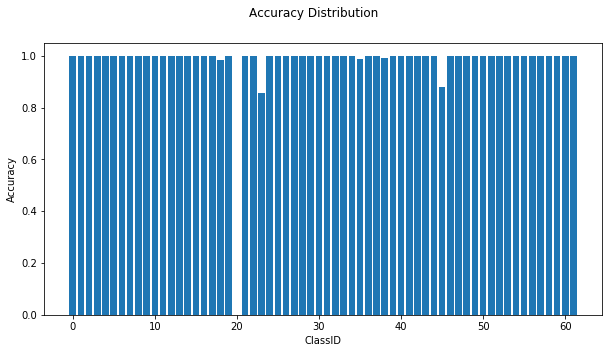

In [0]:
graph_names = list(range(0, 62)) #class ID
plt.figure(1, figsize=(10, 5))
plt.bar(graph_names, accuracy_of_each_class)
plt.suptitle("Accuracy Distribution")
plt.xlabel('ClassID')
plt.ylabel('Accuracy')
plt.show()


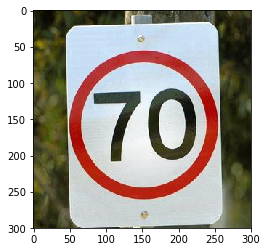

Confidence: 0.999995. The classID for the traffic sign in this picture is: 32
Its class name in the database is: C43
Searching in the image database... It's referening to this one! 


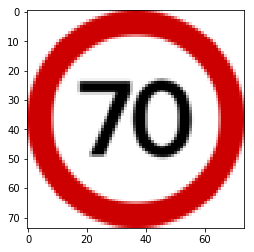

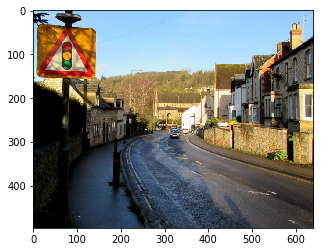

Confidence: 0.4797557. The classID for the traffic sign in this picture is: 19
Its class name in the database is: B1
Searching in the image database... It's referening to this one! 


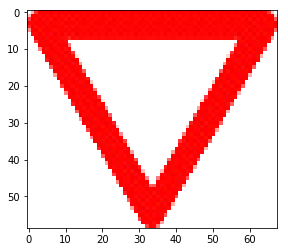

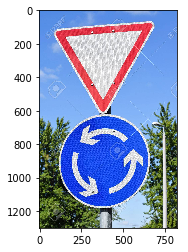

Confidence: 0.4339404. The classID for the traffic sign in this picture is: 19
Its class name in the database is: B1
Searching in the image database... It's referening to this one! 


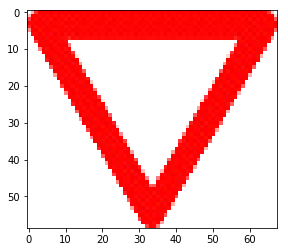

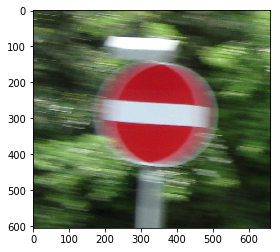

Confidence: 0.94441503. The classID for the traffic sign in this picture is: 22
Its class name in the database is: C1
Searching in the image database... It's referening to this one! 


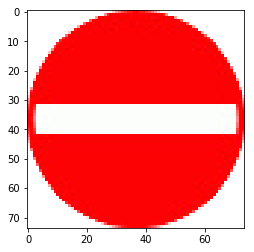

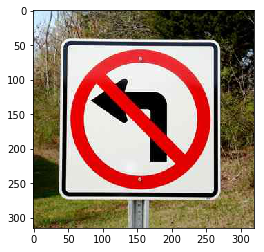

Confidence: 0.99999857. The classID for the traffic sign in this picture is: 29
Its class name in the database is: C31LEFT
Searching in the image database... It's referening to this one! 


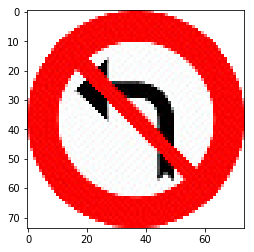

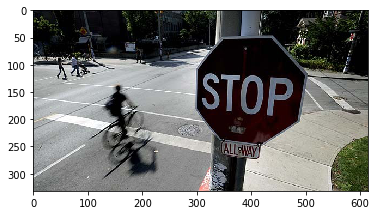

Confidence: 0.84301317. The classID for the traffic sign in this picture is: 21
Its class name in the database is: B5
Searching in the image database... It's referening to this one! 


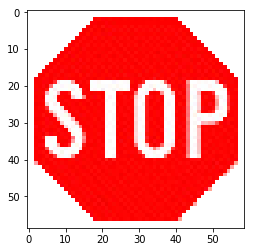

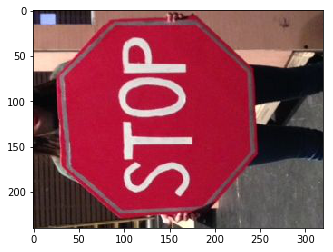

Confidence: 0.8891065. The classID for the traffic sign in this picture is: 21
Its class name in the database is: B5
Searching in the image database... It's referening to this one! 


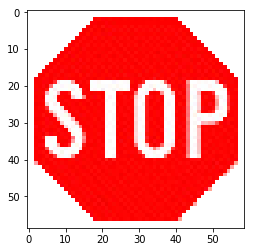

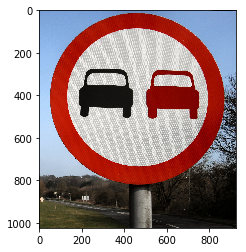

Confidence: 0.99886227. The classID for the traffic sign in this picture is: 31
Its class name in the database is: C35
Searching in the image database... It's referening to this one! 


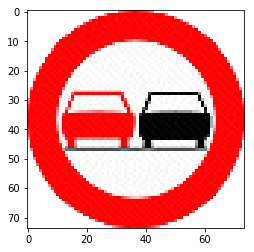

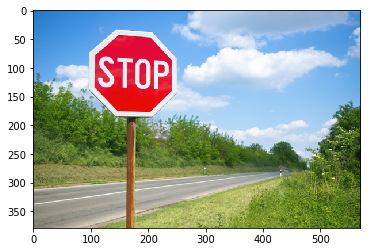

Confidence: 0.4197254. The classID for the traffic sign in this picture is: 19
Its class name in the database is: B1
Searching in the image database... It's referening to this one! 


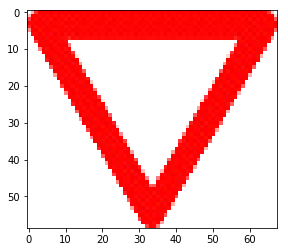

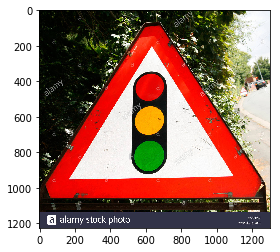

Confidence: 0.98163295. The classID for the traffic sign in this picture is: 13
Its class name in the database is: A51
Searching in the image database... It's referening to this one! 


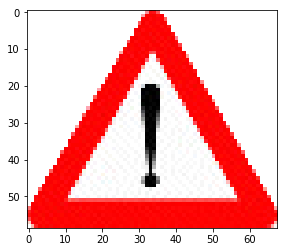

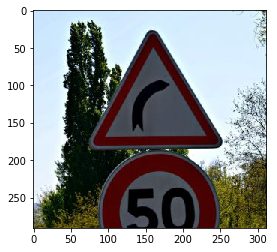

Confidence: 0.94904447. The classID for the traffic sign in this picture is: 4
Its class name in the database is: A1B
Searching in the image database... It's referening to this one! 


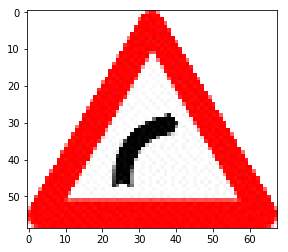

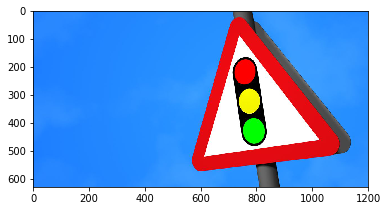

Confidence: 0.7870963. The classID for the traffic sign in this picture is: 13
Its class name in the database is: A51
Searching in the image database... It's referening to this one! 


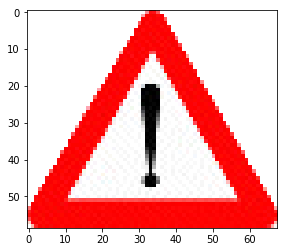

Average time spend for 1 prediction: 1.2158139302180364


In [0]:
# example
# a functiion that predict the traffic sign according to given image 
def predict_img(img_path):
    # will first show the image 
    show_my_image(img_path)
    
    # get model readable format 
    model_use_img = path_to_tensor(img_path).astype('float32')/255
    model_prediction = TS_model.predict(model_use_img)
    model_prediction_index = np.argmax(model_prediction)
    

    print("Confidence: " + str(model_prediction[0][model_prediction_index]) + ". The classID for the traffic sign in this picture is: " + str(model_prediction_index))
    print("Its class name in the database is: " + TSName_62[model_prediction_index])
    print("Searching in the image database... It's referening to this one! ")
    img_name = TSName_62[model_prediction_index] + ".png"
    img_path = os.path.join(standard_folder, img_name)
    show_my_image(img_path)
    
    
test_folder = "/content/drive/My Drive/MLND_Traffic_Sign_Recognition/sample_images"

time_used = []
for eachfile in os.listdir(test_folder):
    start_time = time.time()
    if (eachfile[0]!='.'):
        predict_img(os.path.join(test_folder, eachfile))
    elapsed_time = time.time() - start_time
    time_used.append(elapsed_time)
print("Average time spend for 1 prediction: {}".format(str(np.mean(time_used))))


In [2]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook capstone_tsr.ipynb to html',
 '[NbConvertApp] Writing 2435234 bytes to capstone_tsr.html',
 '[NbConvertApp] Converting notebook TSR_detection.ipynb to html',
 '[NbConvertApp] Writing 339540 bytes to TSR_detection.html']